Simply applying encoding from the sklearn library leads to different codes for a player (team) when it appears in different columns.


1. Only mapping each player (team) to a unique integer, regardless of the column is not good

2. scaling: (CHATGPT:) It is not necessary to use a scaler for categorical features (players and teams) after encoding them with integer values. Scalers are typically used for numerical features to ensure that all features are on the same scale, which can be important for certain machine learning algorithms, particularly those that involve distance calculations or gradient descent optimization. Categorical features that have been encoded with integer values do not require scaling because the integers are used merely as identifiers or labels and do not carry any magnitude or order information. These encoded categorical features are typically treated as discrete variables during model training and inference.



Onehot encoding on the mapped integers is not also good! Since the number of features increases 10 times! Instead we change the data to present_as_home/not-present/present-as-away for each team and player for each row! In this way, we have exactly one column for all teams per row (two of them get the value of 1 and -1 and the rest are 0), and one column for each player per row (5 of them get 1, 5 get -1, and the other ones are 0).


Also Scaling must be applied on only non-categorical features.

In [1]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
#from sklearn.preprocessing import OneHotEncoder
"""from google.colab import drive


drive.mount('/content/drive')
ds_path = '/content/drive/MyDrive/Data_Mining_Project/Datasets/'"""

ds_path = 'Datasets/'
assert os.path.exists(ds_path)

features = ['outcome', 'season', 'home_team','away_team','starting_min','end_min','home_0','home_1','home_2','home_3','home_4','away_0','away_1','away_2','away_3','away_4']
home_players_columns = ['home_0','home_1','home_2','home_3','home_4']
away_players_columns = ['away_0','away_1','away_2','away_3','away_4']


df = pd.DataFrame()
# Load data from matchups-2007.csv to matchups-2011.csv and append them to df
for i in range(2007, 2012):
    df1 = pd.read_csv(ds_path + "matchups-" + str(i) + ".csv")[features]
    print(len(df1))
    df = pd.concat([df, df1])
df.reset_index(drop=True, inplace=True)
print(f"len of final df: {len(df)}")
print("first print \n" + str(df))
print(df.shape)


def encode_teams_names(df):
    global unique_teams
    # Get unique team names
    unique_teams = pd.concat([df['home_team'], df['away_team']]).unique()
    # Initialize a DataFrame with all zeros
    encoded_df = pd.DataFrame(0, index=df.index, columns=unique_teams)
    # Set values for home teams and away teams
    for i in range(df.shape[0]):
      encoded_df.loc[i, df.loc[i, 'home_team']] = 1
      encoded_df.loc[i, df.loc[i, 'away_team']] = -1
    #encoded_df[df['home_team']] = 1 # works incorrect
    #encoded_df[df['away_team']] = -1 # works incorrect
    # Concatenate the encoded team DataFrame with the original DataFrame
    df = pd.concat([df, encoded_df], axis=1)
    # Drop the original home_team and away_team columns
    df = df.drop(['home_team', 'away_team'], axis=1)
    return df


def encode_player_names(df):
    global all_players
    # Get unique player names
    all_players = df[home_players_columns + away_players_columns].stack().unique()
    # Initialize a DataFrame with all zeros
    encoded_df = pd.DataFrame(0, index=df.index, columns=all_players)
    # Set values for home team players and away team players
    for i in range(df.shape[0]):
      encoded_df.loc[i, df.loc[i, home_players_columns]] = 1
      encoded_df.loc[i, df.loc[i, away_players_columns]] = -1
    #encoded_df[df[home_players_columns]] = 1
    #encoded_df[df[away_players_columns]] = -1
    # Concatenate the encoded player DataFrame with the original DataFrame
    df = pd.concat([df, encoded_df], axis=1)
    # Drop the original player columns
    df = df.drop(home_players_columns + away_players_columns, axis=1)
    return df








df = encode_teams_names(df)
print("print after encode teams names \n" + str(df))
#print(df[['LAL', 'PHO', 'MIL', 'CHA']])
df = encode_player_names(df)
print("print after encode players names \n" + str(df))
#print(df[['Smush Parker', 'Boris Diaw', 'Matt Carroll']]) # CHECKED AND CORRECT SO FAR
print(f"size: {df.size}")

X_train = df.drop("outcome", axis=1)
y_train = df["outcome"]


# Feature scaling
columns_to_scale = ['season', 'starting_min', 'end_min']
scaler = StandardScaler()
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])

print("print X_train after encoding and scaling \n" + str(X_train))
print()

27500
26593
26407
26344
26447
len of final df: 133291
first print 
        outcome  season home_team away_team  starting_min  end_min  \
0            -1    2007       LAL       PHO             0        5   
1            -1    2007       LAL       PHO             6        7   
2             1    2007       LAL       PHO             8        9   
3             1    2007       LAL       PHO            10       10   
4            -1    2007       LAL       PHO            11       11   
...         ...     ...       ...       ...           ...      ...   
133286       -1    2011       CHA       MIL            37       37   
133287       -1    2011       CHA       MIL            38       38   
133288       -1    2011       CHA       MIL            39       39   
133289       -1    2011       CHA       MIL            40       43   
133290       -1    2011       CHA       MIL            44       47   

              home_0            home_1            home_2            home_3  \
0       Andrew

So the number of features increased to 763 + 1 target.

The number of training samples is 133,291. We will use 20% of them for validation during training each model.

Overall, a large number of features is not good, but considering the high number of categorical features and also categories, it is the best possible way.

In [6]:
# Load data from matchups_2012.csv and append it to df
df_valid = pd.read_csv(ds_path + "matchups-2012.csv")[features]

def encode_valid_df_based_on_train(valid_df):
    encoded_df = pd.DataFrame(0, index=valid_df.index, columns=list(unique_teams) + list(all_players))
    for i in range(valid_df.shape[0]):
          encoded_df.loc[i, valid_df.loc[i, home_players_columns + ['home_team']]] = 1
          encoded_df.loc[i, valid_df.loc[i, away_players_columns + ['away_team']]] = -1
    valid_df = pd.concat([valid_df, encoded_df], axis=1)
    # Drop the original player columns
    valid_df = valid_df.drop(home_players_columns + away_players_columns + ['home_team', 'away_team'], axis=1)
    valid_df = valid_df.dropna(axis='columns')
    return valid_df


df_valid = encode_valid_df_based_on_train(df_valid)
X_test = df_valid.drop("outcome", axis=1)
y_test = df_valid["outcome"]


X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])
print(X_test)
print(y_test)

         season  starting_min   end_min  LAL  PHO  LAC  SAS  UTA  GSW  POR  \
0      2.125453     -1.895262 -1.641644    0    0    0    0    0    0    0   
1      2.125453     -1.433104 -1.562775    0    0    0    0    0    0    0   
2      2.125453     -1.356078 -1.405038    0    0    0    0    0    0    0   
3      2.125453     -1.202025 -1.247301    0    0    0    0    0    0    0   
4      2.125453     -1.047973 -1.168432    0    0    0    0    0    0    0   
...         ...           ...       ...  ...  ...  ...  ...  ...  ...  ...   
21236  2.125453      1.031738  1.039889    0    0    0    0    0    0    0   
21237  2.125453      1.185791  1.197626    0    0    0    0    0    0    0   
21238  2.125453      1.339844  1.276495    0    0    0    0    0    0    0   
21239  2.125453      1.416870  1.513101    0    0    0    0    0    0    0   
21240  2.125453      1.647949  1.670838    0    0    0    0    0    0    0   

       ...  James Anderson  Devin Ebanks  Lance Stephenson  Gan

The number of test samples is 21241 (and 763 columns), which are from the 2012 dataset.

However, there are some new players and teams...

(array([85405.,     0., 47886.]),
 array([-1.        , -0.33333333,  0.33333333,  1.        ]),
 <BarContainer object of 3 artists>)

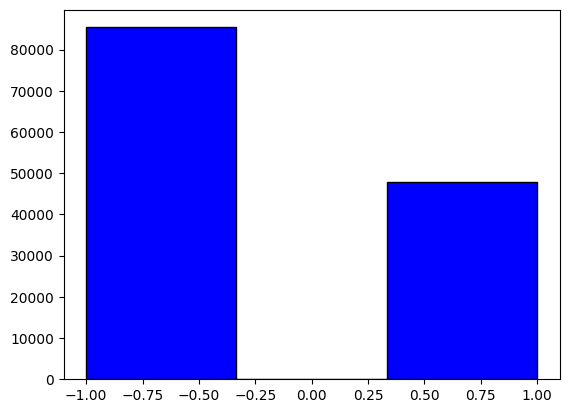

In [7]:
import matplotlib.pyplot as plt
plt.hist(y_train, bins=3, color='blue', edgecolor='black')

(array([13454.,     0.,  7787.]),
 array([-1.        , -0.33333333,  0.33333333,  1.        ]),
 <BarContainer object of 3 artists>)

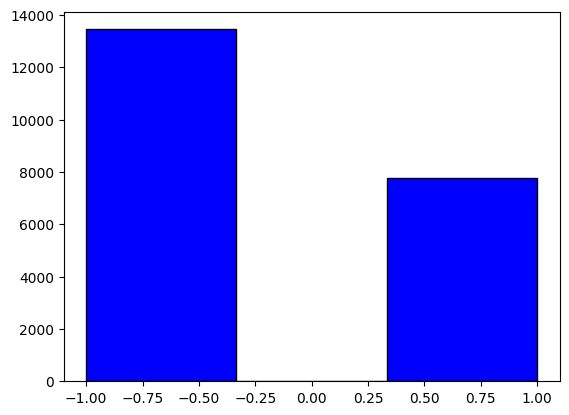

In [8]:
plt.hist(y_test, bins=3, color='blue', edgecolor='black')

In [ ]:
# OLD: without cross_validation - not good

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

list_of_models = [KNeighborsClassifier(n_neighbors=3), SVC(class_weight='balanced'), GaussianNB()]

results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'CM'])
for model in list_of_models:
  print(f"*************** {model} *****************")
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # Evaluate model
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  print(f"Accuracy: {accuracy:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1-score: {f1:.4f}")

  from sklearn.metrics import confusion_matrix

  conf_matrix = confusion_matrix(y_test, y_pred)
  print("Confusion Matrix:")
  print(conf_matrix)
  results_df = results_df.append({'Model': str(model), 'Accuracy': accuracy:.4f,
                                  "Precision": precision:.4f, "Recall": recall:.4f,
                                  "F1-score": f1:.4f,
                                  "CM": conf_matrix}, ignore_index=True)

# Save the results to a CSV file
results_df.to_csv('model_results.csv', index=False)



*************** KNeighborsClassifier(n_neighbors=3) *****************
Accuracy: 0.5773
Precision: 0.3832
Recall: 0.3316
F1-score: 0.3556
Confusion Matrix:
[[12280  5004]
 [ 6266  3109]]
*************** SVC(class_weight='balanced') *****************
Accuracy: 0.5463
Precision: 0.3996
Recall: 0.5777
F1-score: 0.4725
Confusion Matrix:
[[9148 8136]
 [3959 5416]]
*************** GaussianNB() *****************
Accuracy: 0.6483
Precision: 0.4167
Recall: 0.0005
F1-score: 0.0011
Confusion Matrix:
[[17277     7]
 [ 9370     5]]


In [ ]:
!pip install catboost

In [ ]:
!pip install lightgbm

In [10]:
# DO NOT TOUCH
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
#from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


list_of_models = [KNeighborsClassifier(n_neighbors=3),
                  GaussianNB(),
                  LogisticRegression(class_weight='balanced'),
                  RandomForestClassifier(class_weight='balanced'),
                  GradientBoostingClassifier(),
                  #XGBClassifier(),
                  LGBMClassifier(),
                  CatBoostClassifier(verbose=False),
                  #SVC(class_weight='balanced')
                 ]
results_df = pd.DataFrame(columns=['Model', 'Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1-score', 'Mean_Accuracy', 'Std_Accuracy', 'Mean_Precision', 'Std_Precision', 'Mean_Recall', 'Std_Recall', 'Mean_F1-score', 'Std_F1-score'])

for model in list_of_models:
    print(f"*************** {model} *****************")
    cv_results = cross_validate(model, X_train, y_train, cv=5, scoring=['f1', 'precision', 'recall', 'accuracy'])
    y_pred = model.fit(X_train, y_train).predict(X_test)

    # Evaluate model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    results_df = pd.concat([results_df, pd.DataFrame([{'Model': str(model), 'Test Accuracy': round(accuracy, 4),
                                    "Test Precision": round(precision, 4), "Test Recall": round(recall, 4),
                                    "Test F1-score": round(f1, 4),
                                    "Mean_Accuracy": round(cv_results['test_accuracy'].mean(), 4),
                                    "Std_Accuracy": round(cv_results['test_accuracy'].std(), 4),
                                    "Mean_Precision": round(cv_results['test_precision'].mean(), 4),
                                    "Std_Precision": round(cv_results['test_precision'].std(), 4),
                                    "Mean_Recall": round(cv_results['test_recall'].mean(), 4),
                                    "Std_Recall": round(cv_results['test_recall'].std(), 4),
                                    "Mean_F1-score": round(cv_results['test_f1'].mean(), 4),
                                    "Std_F1-score": round(cv_results['test_f1'].std(), 4)}])], ignore_index=True)
# Save the results to a CSV file
#res_path = '/content/drive/MyDrive/Data_Mining_Project/Results/'
res_path = 'Results/'
results_df.to_csv(res_path + 'model_results_macro.csv', index=False)



*************** KNeighborsClassifier(n_neighbors=3) *****************
Accuracy: 0.5795
Precision: 0.5376
Recall: 0.5355
F1-score: 0.5355
*************** GaussianNB() *****************


C:\Users\sevza\AppData\Local\Temp\ipykernel_33784\3265400033.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([{'Model': str(model), 'Test Accuracy': round(accuracy, 4),


Accuracy: 0.4542
Precision: 0.5455
Recall: 0.5329
F1-score: 0.4412
*************** LogisticRegression(class_weight='balanced') *****************
Accuracy: 0.5642
Precision: 0.5682
Recall: 0.5733
F1-score: 0.5580
*************** RandomForestClassifier(class_weight='balanced') *****************
Accuracy: 0.6229
Precision: 0.5512
Recall: 0.5236
F1-score: 0.4890
*************** GradientBoostingClassifier() *****************


C:\Users\sevza\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.6333
Precision: 0.5494
Recall: 0.5004
F1-score: 0.3902
*************** LGBMClassifier() *****************
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 38308, number of negative: 68324
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2070
[LightGBM] [Info] Number of data points in the train set: 106632, number of used features: 659
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.359254 -> initscore=-0.578602
[LightGBM] [Info] Start training from score -0.578602


C:\Users\sevza\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 38309, number of negative: 68324
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2195
[LightGBM] [Info] Number of data points in the train set: 106633, number of used features: 701
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.359260 -> initscore=-0.578576
[LightGBM] [Info] Start training from score -0.578576
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 38309, number of negative: 68324
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force

C:\Users\sevza\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.6338
Precision: 0.5722
Recall: 0.5113
F1-score: 0.4324


In [12]:
# DO NOT TOUCH 2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
#from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


list_of_models2 = [SVC(class_weight='balanced')]

for model in list_of_models2:
    print(f"*************** {model} *****************")
    cv_results = cross_validate(model, X_train, y_train, cv=5, scoring=['f1', 'precision', 'recall', 'accuracy'])
    y_pred = model.fit(X_train, y_train).predict(X_test)

    # Evaluate model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    results_df = pd.concat([results_df, pd.DataFrame([{'Model': str(model), 'Test Accuracy': round(accuracy, 4),
                                    "Test Precision": round(precision, 4), "Test Recall": round(recall, 4),
                                    "Test F1-score": round(f1, 4),
                                    "Mean_Accuracy": round(cv_results['test_accuracy'].mean(), 4),
                                    "Std_Accuracy": round(cv_results['test_accuracy'].std(), 4),
                                    "Mean_Precision": round(cv_results['test_precision'].mean(), 4),
                                    "Std_Precision": round(cv_results['test_precision'].std(), 4),
                                    "Mean_Recall": round(cv_results['test_recall'].mean(), 4),
                                    "Std_Recall": round(cv_results['test_recall'].std(), 4),
                                    "Mean_F1-score": round(cv_results['test_f1'].mean(), 4),
                                    "Std_F1-score": round(cv_results['test_f1'].std(), 4)}])], ignore_index=True)
# Save the results to a CSV file
#res_path = '/content/drive/MyDrive/Data_Mining_Project/Results/'
res_path = 'Results/'
results_df.to_csv(res_path + 'model_results_macro.csv', index=False)



*************** SVC(class_weight='balanced') *****************
Accuracy: 0.5420
Precision: 0.5770
Recall: 0.5784
F1-score: 0.5419


Let's try some Neural Networks.

In [16]:
import numpy as np

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = np.where(y_train == -1, 0.0, 1.0)  # Convert -1 to 0
y_test = np.where(y_test == -1, 0.0, 1.0)    # Convert -1 to 0

print(y_train_bu[:3])
print(y_train[:3])

0   -1
1   -1
2    1
Name: outcome, dtype: int64
[0. 0. 1.]


In [17]:
X_train_bu = X_train.copy()
X_test_bu = X_test.copy
y_train_bu = y_train.copy()
y_test_bu = y_test.copy()

print(y_train_bu[:3])
print(y_train[:3])

[0. 0. 1.]
[0. 0. 1.]


In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization

def select_model(num):
    global model
    if num == 1:
        model = Sequential([
                    Dense(512, input_shape=(763,), activation='relu'),
                    #BatchNormalization(),  # Batch Normalization layer after Dense layer
                    Dense(256, activation='relu'),
                    #BatchNormalization(),  # Batch Normalization layer after Dense layer
                    Dense(128, activation='relu'),
                    #BatchNormalization(),  # Batch Normalization layer after Dense layer
                    Dense(64, activation='relu'),
                    #BatchNormalization(),  # Batch Normalization layer after Dense layer
                    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation
                ])
    elif num == 2:
        model = Sequential([
                    Dense(256, input_shape=(763,), activation='relu'),
                    #BatchNormalization(),  # Batch Normalization layer after Dense layer
                    Dense(128, activation='relu'),
                    #BatchNormalization(),  # Batch Normalization layer after Dense layer
                    Dense(64, activation='relu'),
                    #BatchNormalization(),  # Batch Normalization layer after Dense layer
                    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation
                ])
    elif num == 3:
        model = Sequential([
                    Dense(256, input_shape=(763,), activation='relu'),
                    BatchNormalization(),  # Batch Normalization layer after Dense layer
                    Dense(128, activation='relu'),
                    BatchNormalization(),  # Batch Normalization layer after Dense layer
                    Dense(64, activation='relu'),
                    BatchNormalization(),  # Batch Normalization layer after Dense layer
                    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation
                ])

    elif num == 4:
        model = Sequential([
                    Dense(128, input_shape=(763,), activation='relu'),
                    #BatchNormalization(),  # Batch Normalization layer after Dense layer
                    Dense(64, activation='relu'),
                    #BatchNormalization(),  # Batch Normalization layer after Dense layer
                    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation
                ])
    elif num == 5:
        model = Sequential([
                    Dense(128, input_shape=(763,), activation='relu'),
                    BatchNormalization(),  # Batch Normalization layer after Dense layer
                    Dense(64, activation='relu'),
                    BatchNormalization(),  # Batch Normalization layer after Dense layer
                    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation
                ])

Due to the time-limitation, we do not use cross-validation for the neural nets. Instead, we use the validation set (with the ratio of 0.2) to find the best model and prevent overfitting.

#%tensorboard --logdir logs..../fit

In [37]:
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from numpy.random import seed
import numpy as np
import shutil

epochs = 20

def lr_schedule(epoch):
    """Learning rate schedule function."""
    initial_lr = 0.001
    if epoch < epochs / 4:
        return initial_lr
    else:
        return initial_lr * np.exp(-0.1 * epoch)

# Splitting data into training and validation sets



def train_NN(mod_num):
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_score_list = []
    for a_seed in range(100, 111):
        np.random.seed(a_seed)
        seed(a_seed)
        select_model(mod_num)
        
        X_train, X_val, y_train, y_val = train_test_split(X_train_bu, y_train_bu, test_size=0.2, random_state=a_seed)
        
        lr_scheduler = LearningRateScheduler(lr_schedule)
        
        # Compile the model
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                               tf.keras.metrics.Precision(name='precision'),
                               tf.keras.metrics.Recall(name='recall'),
                               tf.keras.metrics.F1Score(name='f1_score', average='macro')])
        
        
        # Train the model
        history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=False,
                            callbacks=[lr_scheduler])

        loss, accuracy, precision, recall, f1_score = model.evaluate(X_val, y_val)
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_score_list.append(f1_score)


    
    
    # Retrain and Evaluate the model
    # Clear log directory if it exists
    log_dir = "logs_ModelNum" + str(mod_num) + "/fit/"
    if os.path.exists(log_dir):
        shutil.rmtree(log_dir)
    os.makedirs(log_dir)
    sm_checkpoint = tf.keras.callbacks.ModelCheckpoint(res_path + 'checkpoints/best_model_' + str(mod_num) + '.h5', 
                                							monitor='val_f1_score', verbose=0, 
                                							save_best_only=True, mode='max')
    # Define TensorBoard callback
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    select_model(mod_num)
    lr_scheduler = LearningRateScheduler(lr_schedule)
    
    model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                               tf.keras.metrics.Precision(name='precision'),
                               tf.keras.metrics.Recall(name='recall'),
                               tf.keras.metrics.F1Score(name='f1_score', average='macro')])

    model.summary()
    history = model.fit(X_train_bu, y_train_bu, epochs=epochs, validation_data=(X_test, y_test), verbose=False,
                            callbacks=[tensorboard_callback, lr_scheduler, sm_checkpoint])

    loss, accuracy, precision, recall, f1_score = model.evaluate(X_test, y_test)
    
    print(f'Test Loss: {loss:.4f}')
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test Precision: {precision:.4f}')
    print(f'Test Recall: {recall:.4f}')
    print(f'Test F1 Score: {f1_score:.4f}')
    print()
    print("From Cross_validation:")
    print(f"Accuracy: {np.mean(accuracy_list):.4f}, std: {np.std(accuracy_list):.4f}")
    print(f"Precision: {np.mean(precision_list):.4f}, std: {np.std(precision_list):.4f}")
    print(f"Recall: {np.mean(recall_list):.4f}, std: {np.std(recall_list):.4f}")
    print(f"F1-Score: {np.mean(f1_score_list):.4f}, std: {np.std(f1_score_list):.4f}")

    

In [38]:
train_NN(1)

834/834 [==============================] - 1s 1ms/step - loss: 5.6121 - accuracy: 0.5703 - precision: 0.3967 - recall: 0.3895 - f1_score: 0.5492
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_104 (Dense)           (None, 512)               391168    
                                                                 
 dense_105 (Dense)           (None, 256)               131328    
                                                                 
 dense_106 (Dense)           (None, 128)               32896     
                                                                 
 dense_107 (Dense)           (None, 64)                8256      
                                                                 
 dense_108 (Dense)           (None, 1)                 65        
                                                                 
Total params: 563713 (2.15 MB)
Trainable

C:\Python-3.11.4\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


664/664 [==============================] - 1s 1ms/step - loss: 4.7983 - accuracy: 0.5692 - precision: 0.4181 - recall: 0.4474 - f1_score: 0.5636
Test Loss: 4.7983
Test Accuracy: 0.5692
Test Precision: 0.4181
Test Recall: 0.4474
Test F1 Score: 0.5636

From Cross_validation:
Accuracy: 0.5763, std: 0.0038
Precision: 0.4098, std: 0.0056
Recall: 0.4011, std: 0.0095
F1-Score: 0.5584, std: 0.0048


In [39]:
train_NN(2)

834/834 [==============================] - 1s 1ms/step - loss: 3.7933 - accuracy: 0.5743 - precision: 0.3996 - recall: 0.3809 - f1_score: 0.5624
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_153 (Dense)           (None, 256)               195584    
                                                                 
 dense_154 (Dense)           (None, 128)               32896     
                                                                 
 dense_155 (Dense)           (None, 64)                8256      
                                                                 
 dense_156 (Dense)           (None, 1)                 65        
                                                                 
Total params: 236801 (925.00 KB)
Trainable params: 236801 (925.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


C:\Python-3.11.4\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


664/664 [==============================] - 1s 1ms/step - loss: 3.1856 - accuracy: 0.5681 - precision: 0.4223 - recall: 0.4836 - f1_score: 0.5717
Test Loss: 3.1856
Test Accuracy: 0.5681
Test Precision: 0.4223
Test Recall: 0.4836
Test F1 Score: 0.5717

From Cross_validation:
Accuracy: 0.5778, std: 0.0034
Precision: 0.4109, std: 0.0063
Recall: 0.3974, std: 0.0107
F1-Score: 0.5667, std: 0.0026


In [40]:
train_NN(3)

834/834 [==============================] - 1s 1ms/step - loss: 1.1268 - accuracy: 0.5750 - precision: 0.3996 - recall: 0.3770 - f1_score: 0.5265
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_201 (Dense)           (None, 256)               195584    
                                                                 
 batch_normalization_38 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 dense_202 (Dense)           (None, 128)               32896     
                                                                 
 batch_normalization_39 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_203 (Dense)           (None, 64) 

C:\Python-3.11.4\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


664/664 [==============================] - 1s 1ms/step - loss: 1.0276 - accuracy: 0.5673 - precision: 0.4153 - recall: 0.4420 - f1_score: 0.5365
Test Loss: 1.0276
Test Accuracy: 0.5673
Test Precision: 0.4153
Test Recall: 0.4420
Test F1 Score: 0.5365

From Cross_validation:
Accuracy: 0.5790, std: 0.0027
Precision: 0.4107, std: 0.0056
Recall: 0.3891, std: 0.0101
F1-Score: 0.5295, std: 0.0024


In [41]:
train_NN(4)

834/834 [==============================] - 1s 805us/step - loss: 1.1227 - accuracy: 0.5782 - precision: 0.4014 - recall: 0.3678 - f1_score: 0.5745
Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_238 (Dense)           (None, 128)               97792     
                                                                 
 dense_239 (Dense)           (None, 64)                8256      
                                                                 
 dense_240 (Dense)           (None, 1)                 65        
                                                                 
Total params: 106113 (414.50 KB)
Trainable params: 106113 (414.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


C:\Python-3.11.4\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


664/664 [==============================] - 1s 817us/step - loss: 1.0812 - accuracy: 0.5770 - precision: 0.4211 - recall: 0.4102 - f1_score: 0.5791
Test Loss: 1.0812
Test Accuracy: 0.5770
Test Precision: 0.4211
Test Recall: 0.4102
Test F1 Score: 0.5791

From Cross_validation:
Accuracy: 0.5785, std: 0.0037
Precision: 0.4084, std: 0.0057
Recall: 0.3803, std: 0.0094
F1-Score: 0.5775, std: 0.0022


In [42]:
train_NN(5)

834/834 [==============================] - 1s 887us/step - loss: 0.8968 - accuracy: 0.5809 - precision: 0.4047 - recall: 0.3673 - f1_score: 0.5265
Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_274 (Dense)           (None, 128)               97792     
                                                                 
 batch_normalization_63 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_275 (Dense)           (None, 64)                8256      
                                                                 
 batch_normalization_64 (Ba  (None, 64)                256       
 tchNormalization)                                               
                                                                 
 dense_276 (Dense)           (None, 1)

C:\Python-3.11.4\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


664/664 [==============================] - 1s 852us/step - loss: 0.8093 - accuracy: 0.5749 - precision: 0.4155 - recall: 0.3921 - f1_score: 0.5365
Test Loss: 0.8093
Test Accuracy: 0.5749
Test Precision: 0.4155
Test Recall: 0.3921
Test F1 Score: 0.5365

From Cross_validation:
Accuracy: 0.5820, std: 0.0029
Precision: 0.4114, std: 0.0045
Recall: 0.3733, std: 0.0078
F1-Score: 0.5295, std: 0.0024


In [87]:
# Leave it (not important)


import sklearn
y_pred = model.predict(X_test)
y_pred = np.where(y_pred >= 0.5, 1, 0)
# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = sklearn.metrics.f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

834/834 [==============================] - 1s 731us/step
Accuracy: 0.5801
Precision: 0.4022
Recall: 0.3989
F1-score: 0.4006
